## <center>**Deteksi spam email menggunakan word2vec**</center>

## <center> Observing Data</center>

In [1]:
import pandas as pd
df = pd.read_csv('spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


**Memahami tipe data kolom dalam dataframe**

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


Penjelasan
1. `<class 'pandas.core.frame.DataFrame'>`: objek yang yangperiksa adalah sebuah dataframe dari Pandas.

2. `RangeIndex: 5171 entries, 0 to 5170`: dataframe memiliki indeks dengan jangkauan (range) dari 0 hingga 5170 dengan total 5171 entri (baris).

3. `Data columns (total 4 columns)`: terdapat 4 kolom (atribut) dalam dataframe.

4. `#   Column      Non-Null Count  Dtype`:
   - `#`: No indeks kolom (mulai dari 0).
   - `Column`: Nama kolom.
   - `Non-Null Count`: Jumlah nilai non-null (non-kosong) dalam kolom tersebut. Ini memberi tahu berapa banyak entri yang tidak kosong dalam kolom.
   - `Dtype`: Tipe data dari kolom tersebut.

5. `dtypes: int64(2), object(2)`: dalam dataframe ini terdapat dua kolom dengan tipe data `int64` (bilangan bulat) dan dua kolom dengan tipe data `object` (biasanya digunakan untuk data berjenis teks).

6. `memory usage: 161.7+ KB`: Ini menunjukkan perkiraan penggunaan memori untuk dataframe, yang dihitung sebagai sekitar 161.7 kilobyte.

**Memeriksa apakah data mengandung nilai null (NaN)**

In [3]:
df.isna().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

**Membuat perbandingan antara email spam dan email biasa menggunakan countplot dari seaborn**

<AxesSubplot: xlabel='label', ylabel='count'>

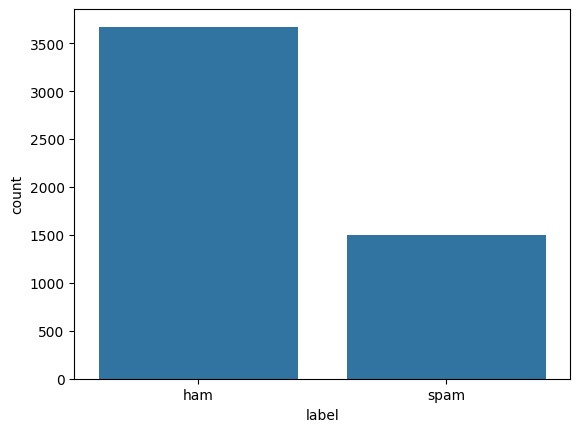

In [4]:
import seaborn as sns
sns.countplot(x="label",data=df)

## <center> Data Cleaning </center>

In [5]:
print(df['text'][0])

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


In [6]:
!pip install contractions

In [7]:
import contractions
# untuk mengembangkan kontraksi dlm bahasa inggris ke bentuk asli. contoh : I'll to "I will"
from tqdm import tqdm
# tqdm package is used to track the progress of work. It displays the percentage of loop done.
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
# download stopwords dalam bahasa inggris
stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
processed_emails=[]
for i in tqdm(df['text']):
    #menghapus tag html
    i=re.sub('(<[\w\s]*/?>)',"",i)
    i=contractions.fix(i)
    #menghapus karakter khusus, sehingga yang tersisa hanya huruf, angka, dan spasi
    i=re.sub('[^a-zA-Z0-9\s]+',"",i)
    #menghapus semua digit(angka)
    i=re.sub('\d+',"",i)
    #mengubah menjadi huruf kecil, menghapus kata" jika tidak ada distopwords dan jika panjangnya kurang dari 3
    processed_emails.append(" ".join([j.lower() for j in i.split() if j not in stopwords and len(j)>=3]))

  4%|▍         | 213/5171 [00:00<00:04, 1077.69it/s]

100%|██████████| 5171/5171 [00:09<00:00, 535.17it/s]


In [9]:
processed_df=pd.DataFrame({'text':processed_emails,'Spam/Ham':list(df['label_num'])})
processed_df.head()

,text,Spam/Ham
0,subject enron methanol meter follow note gave ...,0
1,subject hpl nom january see attached file hpln...,0
2,subject neon retreat around wonderful time yea...,0
3,subject photoshop windows office cheap main tr...,1
4,subject indian springs deal book teco pvr reve...,0


# **TRAIN MODEL**

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## <center> Data Preparation </center>

In [11]:
X=processed_df['text']
Y=processed_df['Spam/Ham']
# memisahkan data, 20% untuk testing dan 80% untuk training
x_train,x_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.20)

**Membuat data untuk melatih model word2vec**

In [12]:
words_in_sentences=[]
for i in tqdm(x_train):
    words_in_sentences.append(i.split())

100%|██████████| 4136/4136 [00:00<00:00, 70652.99it/s]


In [13]:
model = Word2Vec(sentences=words_in_sentences, vector_size=200,workers=-1)

**Jumlah kata dalam Kosakata yang digunakan dalam pelatihan model Word2Vec.**

In [15]:
kosakata=list(model.wv.key_to_index.keys())
print(len(kosakata))

7287


**Average Word2Vec for converting a given Sentence into numerical vector.**


In [17]:
import numpy as np
def avg_w2vec(kalimat):
    hasil_transformasi = []
    for kalimat_teks in tqdm(kalimat):
        hitung = 0 # menghitung berapa banyak kata yang ada dalam kalimat yg termasuk dlm kosakata
        vektor = np.zeros(200) # vektor 0 dgn panjang 200 yg akan digunakan utk menghitung rata" vektor kata" dlm kalimat
        for kata in kalimat_teks.split(): # mengambil setiap kata dalam kalimat (dibagi berdasar spasi)
            if kata in kosakata:
                vektor += model.wv.get_vector(kata) # vektor kata tsb akan diambil dr model word2vec dan ditambahkan ke 'vektor'
                hitung += 1 # jumlah kata yang valid akan ditambahkan ke 'hitung'
        if hitung != 0:
            vektor / hitung
            hasil_transformasi.append(vektor)
        else:
            print(kalimat_teks)
    return np.array(hasil_transformasi)

merepresentasi numerik dari setiap kalimat dalam `x_train` dan `x_test` sebagai vektor rata-rata

In [18]:
x_train_hasil_transformasi=avg_w2vec(x_train)
x_test_hasil_transformasi=avg_w2vec(x_test)

100%|██████████| 1035/1035 [00:14<00:00, 73.31it/s]


In [31]:
# Inisialisasi model SVM
svm_model = SVC(kernel='linear')
svm_model.fit(x_train_hasil_transformasi, y_train)

y_pred = svm_model.predict(x_test_hasil_transformasi)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Akurasi:", accuracy)
print("Classification Report:\n", report)

Akurasi: 0.8927536231884058
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       735
           1       0.90      0.71      0.79       300

    accuracy                           0.89      1035
   macro avg       0.89      0.84      0.86      1035
weighted avg       0.89      0.89      0.89      1035



In [32]:
from sklearn import metrics
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[710,  25],
       [ 86, 214]])

In [33]:
# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))
# precision
print("precision", metrics.precision_score(y_test, y_pred))
# recall
print("recall", metrics.recall_score(y_test, y_pred))
# F1-Score
print("F1-Score", metrics.f1_score(y_test, y_pred))

accuracy 0.8927536231884058
precision 0.895397489539749
recall 0.7133333333333334
F1-Score 0.7940630797773655


In [34]:
# spesifisitas (% ham yang diklasifikasikan)\
# kalkulasi dengan rumus a/(a+b)
# a = baris pertama kolom pertama
# b = baris pertama kolom kedua
print("specificity", 710/(710+25))

specificity 0.9659863945578231


In [19]:
# membuat objek KFold dengan 5 pemisahan
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)
# menginstansiasi sebuah model dengan biaya = 1
model = SVC(C = 1)

In [21]:
# menghitung skor validasi silang
cv_results = cross_val_score(model, x_train_hasil_transformasi, y_train, cv = folds, scoring = 'accuracy')

In [23]:
# print 5 akurasi yang diperoleh dari 5 lipatan
print(cv_results)
print("rata-rata akurasi = {}".format(cv_results.mean()))

[0.92270531 0.89721886 0.904474   0.9165659  0.91414752]
rata-rata akurasi = 0.9110223203593689


In [24]:
params = {"C": [0.1, 1, 10, 100]}

model = SVC()

# mengatur skema pencarian grid
# perhatikan bahwa kita masih menggunakan skema CV 5 kali lipat yang telah kita siapkan sebelumnya
model_cv = GridSearchCV(estimator = model, param_grid = params,
                        scoring= 'accuracy',
                        cv = folds,
                        verbose = 1,
                       return_train_score=True)

In [25]:
# cocok dengan model - model ini akan cocok dengan 5 lipatan di semua nilai C
model_cv.fit(x_train_hasil_transformasi, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(), param_grid={'C': [0.1, 1, 10, 100]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [26]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.343816,0.927561,1.686874,0.553017,0.1,{'C': 0.1},0.724638,0.709794,0.709794,0.718259,...,0.719051,0.008848,4,0.717352,0.720762,0.719251,0.722273,0.718646,0.719657,0.001707
1,3.458840,1.891414,1.078804,0.545564,1,{'C': 1},0.922705,0.897219,0.904474,0.916566,...,0.911022,0.009060,3,0.936215,0.939559,0.929586,0.936839,0.941976,0.936835,0.004166
2,1.410272,0.436205,0.363479,0.046228,10,{'C': 10},0.922705,0.909311,0.918984,0.915357,...,0.916343,0.004446,1,0.958888,0.958900,0.954971,0.960109,0.963433,0.959260,0.002713
3,1.920521,0.703607,0.389369,0.140278,100,{'C': 100},0.915459,0.900846,0.912938,0.921403,...,0.912959,0.006718,2,0.977630,0.978241,0.977939,0.978543,0.980054,0.978482,0.000843


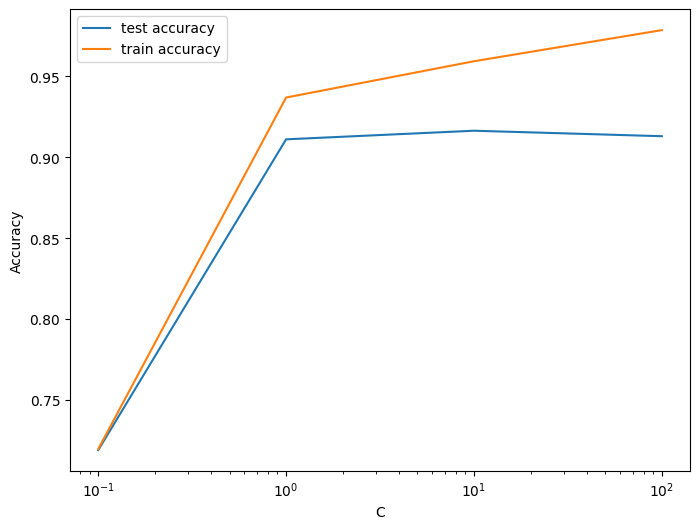

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [28]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" Akurasi test tertinggi adalah {0} dengan C = {1}".format(best_score, best_C))

 Akurasi test tertinggi adalah 0.9163427556677123 dengan C = 10


# <center> Model Evaluation </center>

* fpr : false positive rate
* tpr : true positive rate

In [29]:
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
train_fpr,train_tpr,thresholds=roc_curve(y_train,clf.predict_proba(x_train_hasil_transformasi)[:,1])
test_fpr,test_tpr,thresholds=roc_curve(y_test,clf.predict_proba(x_test_hasil_transformasi)[:,1])

NameError: name 'clf' is not defined

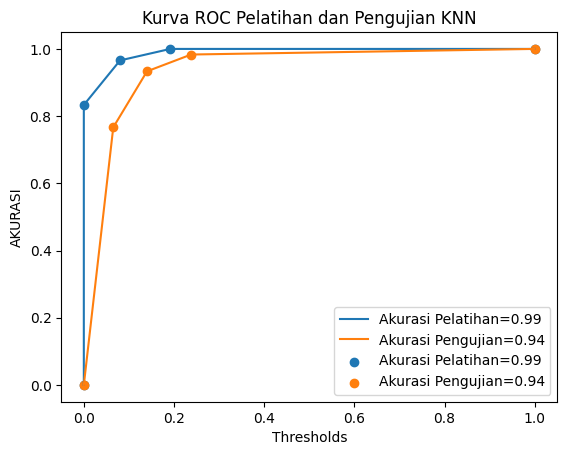

In [ ]:
import matplotlib.pyplot as plt

# Membuat plot untuk kurva ROC pada data pelatihan dan pengujian
plt.plot(train_fpr, train_tpr, label="Akurasi Pelatihan=" + str(round(auc(train_fpr, train_tpr), 2)))
plt.plot(test_fpr, test_tpr, label="Akurasi Pengujian=" + str(round(auc(test_fpr, test_tpr), 2)))

# Menambahkan titik-titik pada kurva ROC
plt.scatter(train_fpr, train_tpr, label="Akurasi Pelatihan=" + str(round(auc(train_fpr, train_tpr), 2)))
plt.scatter(test_fpr, test_tpr, label="Akurasi Pengujian=" + str(round(auc(test_fpr, test_tpr), 2)))
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("AKURASI")
plt.title("Kurva ROC Pelatihan dan Pengujian KNN")
plt.show()

### **Confusion Matrix and Classification Report**

In [ ]:
print(classification_report(y_train,clf.predict(x_train_hasil_transformasi)))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2937
           1       0.83      0.97      0.89      1199

    accuracy                           0.93      4136
   macro avg       0.91      0.94      0.92      4136
weighted avg       0.94      0.93      0.93      4136



In [ ]:
print(classification_report(y_test,clf.predict(x_test_hasil_transformasi)))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       735
           1       0.73      0.93      0.82       300

    accuracy                           0.88      1035
   macro avg       0.85      0.90      0.87      1035
weighted avg       0.90      0.88      0.88      1035

